<a href="https://colab.research.google.com/github/bnv20/cakd3/blob/main/dl_introduction_to_gans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://lifeignite.tistory.com/53

https://ysbsb.github.io/gan/2020/06/17/GAN-newbie-guide.html

GAN 구조는 다음과 같습니다:

1.	`generator` 네트워크는 `(latent_dim,)` 크기의 벡터를 `(32, 32, 3)` 크기의 이미지로 매핑합니다.
2.	`discriminator` 네트워크는 (32, 32, 3) 크기의 이미지가 진짜일 확률을 추정하여 이진 값으로 매핑합니다.
3.	생성자와 판별자를 연결하는 `gan` 네트워크를 만듭니다. `gan(x) = discriminator(generator(x))` 입니다. 이 `gan` 네트워크는 잠재 공간의 벡터를 판별자의 평가로 매핑합니다. 판별자는 생성자가 잠재 공간의 벡터를 디코딩한 것이 얼마나 현실적인지를 평가합니다.
4.	“진짜"/”가짜" 레이블과 함께 진짜 이미지와 가짜 이미지 샘플을 사용해 판별자를 훈련합니다. 일반적인 이미지 분류 모델을 훈련하는 것과 동일합니다.
5. 생성자를 훈련하려면 `gan` 모델의 손실에 대한 생성자 가중치의 그래디언트를 사용합니다. 이 말은 매 단계마다 생성자에 의해 디코딩된 이미지를 판별자가 “진짜"로 분류하도록 만드는 방향으로 생성자의 가중치를 이동한다는 뜻입니다. 다른 말로하면 판별자를 속이도록 생성자를 훈련합니다.

In [1]:
import tensorflow as tf
tf.__version__

'2.7.0'

In [3]:
# 생성자

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = keras.Input(shape=(latent_dim,))

# 입력을 16 x 16 크기의 128개 채널을 가진 특성 맵으로 변환 
x = layers.Dense(128*16*16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16,16,128))(x)

# 합성곱 층을 추가
x = layers.Conv2D(256,5,padding='same')(x)
x = layers.LeakyReLU()(x)

# 32 x 32 크기의 업샘플링
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

# 합성곱 층을 더 추가
x = layers.Conv2D(256,5,padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256,5,padding='same')(x)
x = layers.LeakyReLU()(x)

# 32 x 32 크기의 1개 채널을 가진 특성 맵을 생성
x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = keras.models.Model(generator_input,x)
generator.summary()




Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_1 (Dense)             (None, 32768)             1081344   
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 32768)             0         
                                                                 
 reshape_1 (Reshape)         (None, 16, 16, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 256)       819456    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 256)      104883

In [4]:
# 판별자

discriminator_input = layers.Input(shape=(height,width,channels))
x = layers.Conv2D(128,3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128,4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128,4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128,4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)

x = layers.Dropout(0.4)(x)

# 분류 층
x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input,x)
discriminator.summary()

discriminator_optimizer = keras.optimizers.RMSprop(learning_rate=0.0008, clipvalue=1.0,decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 30, 30, 128)       3584      
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 30, 30, 128)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 128)       262272    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 6, 6, 128)         262272    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 6, 6, 128)         0   

In [5]:
# 판별자의 가중치가 훈련되지 않도록 설정

discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(learning_rate=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

In [7]:
import os
from tensorflow.keras.preprocessing import image
(x_train,y_train),(_,_) = keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 4s 0us/step


In [8]:
x_train.shape

(50000, 32, 32, 3)

In [9]:
import pandas as pd
pd.DataFrame(y_train).value_counts()

9    5000
8    5000
7    5000
6    5000
5    5000
4    5000
3    5000
2    5000
1    5000
0    5000
dtype: int64

In [10]:
x_train = x_train[y_train.flatten()==6]

In [12]:
x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)).astype('float32')/255.

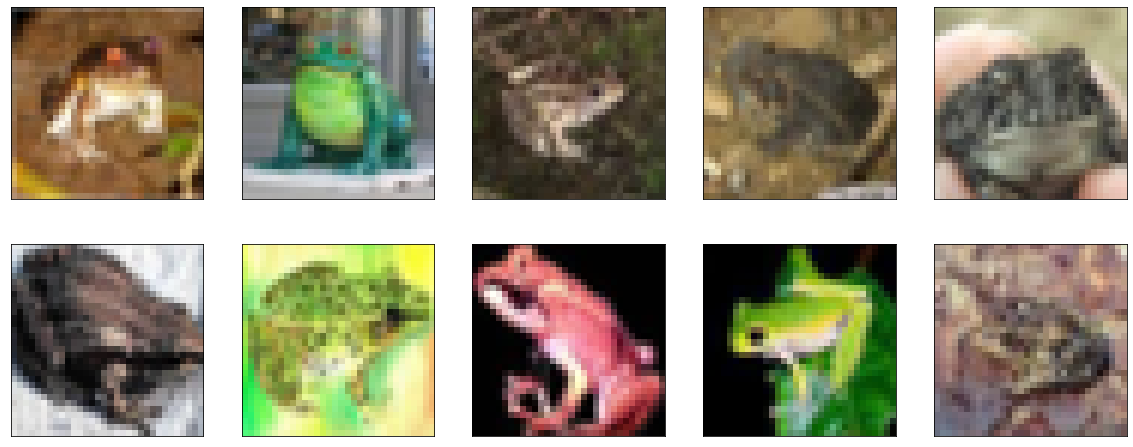

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,8))
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(x_train[i])
  plt.xticks([])
  plt.yticks([])
plt.show()
plt.close()

In [14]:
os.mkdir('./datasets')

In [15]:
iterations = 10000
batch_size = 20
save_dir = './datasets/gan_images/'
if not os.path.exists(save_dir):
  os.mkdir(save_dir)

start = 0
for step in range(iterations):
  # 잠재 공간에서 무작위로 포인트를 샘플링
  random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

  # 가짜 이미지를 디코딩
  generated_images = generator.predict(random_latent_vectors)
  
  # 진짜 이미지와 연결
  stop = start + batch_size
  real_images = x_train[start:stop]
  combined_images = np.concatenate([generated_images, real_images])

  # 진짜와 가짜 이미지를 구분하여 레이블을 합침
  labels = np.concatenate([np.ones((batch_size,1)),
                           np.zeros((batch_size,1))])
  
  # 레이블에 랜덤 노이즈를 추가
  labels += 0.05 * np.random.random(labels.shape)

  # discriminator 훈련
  d_loss = discriminator.train_on_batch(combined_images, labels)

  # 잠재 공간에서 무작위로 포인트 샘플링
  random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

  # 모두 진짜 이미지라고 레이블을 만듬
  misleading_targets = np.zeros((batch_size,1))

  # generator 훈련
  a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)

  start += batch_size
  if start > len(x_train) - batch_size:
    start = 0

  if step % 100 == 0:
    gan.save_weights('gan.h5')

    print('스탭 %s에서 판별자 손실: %s' % (step,d_loss))
    print('스탭 %s에서 적대적 손실: %s' % (step,a_loss))

    # 생성된 이미지 하나를 저정
    img = image.array_to_img(generated_images[0] * 255., scale=False)
    img.save(os.path.join(save_dir, 'generated_frog' + str(step) + '.png'))

    # 비교를 위하여 진짜 이미지 하나를 저장
    img = image.array_to_img(real_images[0] * 255., scale=False)
    img.save(os.path.join(save_dir,'real_frog' + str(step)+'.png'))

    


스탭 0에서 판별자 손실: 0.7014290690422058
스탭 0에서 적대적 손실: 0.6704720258712769
스탭 100에서 판별자 손실: 0.7059141993522644
스탭 100에서 적대적 손실: 0.7395094633102417
스탭 200에서 판별자 손실: 0.7093284130096436
스탭 200에서 적대적 손실: 0.6837669610977173
스탭 300에서 판별자 손실: 0.6709370613098145
스탭 300에서 적대적 손실: 0.8064794540405273
스탭 400에서 판별자 손실: 0.7049662470817566
스탭 400에서 적대적 손실: 0.7562891244888306
스탭 500에서 판별자 손실: 0.6967183947563171
스탭 500에서 적대적 손실: 0.751322865486145
스탭 600에서 판별자 손실: 0.694357693195343
스탭 600에서 적대적 손실: 0.7389208078384399
스탭 700에서 판별자 손실: 0.6923010349273682
스탭 700에서 적대적 손실: 0.7879111170768738
스탭 800에서 판별자 손실: 0.6841526031494141
스탭 800에서 적대적 손실: 0.7501764893531799
스탭 900에서 판별자 손실: 0.6850121021270752
스탭 900에서 적대적 손실: 0.7697135210037231
스탭 1000에서 판별자 손실: 0.6883987188339233
스탭 1000에서 적대적 손실: 0.7446467280387878
스탭 1100에서 판별자 손실: 0.6904754042625427
스탭 1100에서 적대적 손실: 0.7664247751235962
스탭 1200에서 판별자 손실: 0.693816065788269
스탭 1200에서 적대적 손실: 0.7388930916786194
스탭 1300에서 판별자 손실: 0.6993974447250366
스탭 1300에서 적대적 손실: 0.76997435

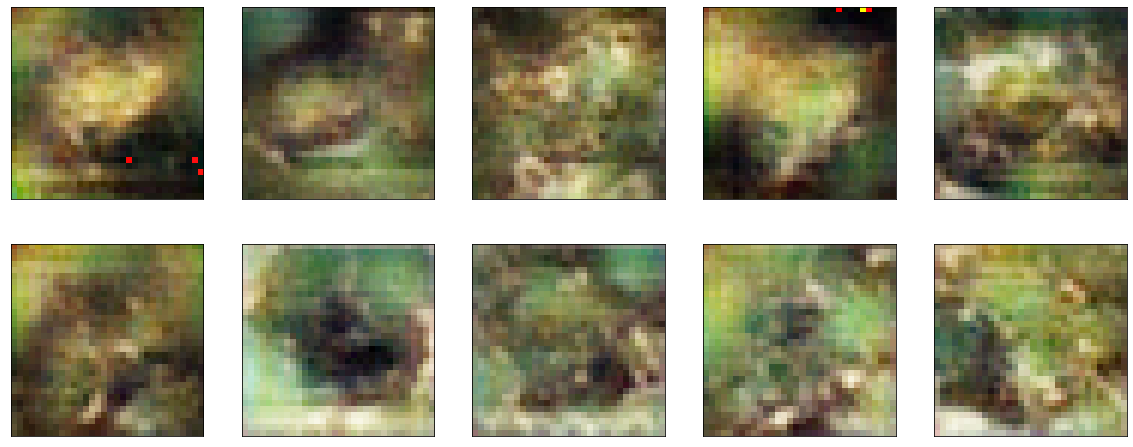

In [16]:
# 가짜 이미지 몇개를 출력

random_latent_vectors = np.random.normal(size=(10,latent_dim))
generated_images = generator.predict(random_latent_vectors)
plt.figure(figsize=(20,8))
for i in range(generated_images.shape[0]):
  plt.subplot(2,5,i+1)
  img = image.array_to_img(generated_images[i] * 255., scale=False)
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
plt.show()
plt.close()